/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:76: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


Directory already exists: /DeepLearning/mnt/shixiansheng/data_fusion/output/Map_2011_FtA_Barron's Script


  0%|          | 0/1 [00:00<?, ?it/s]

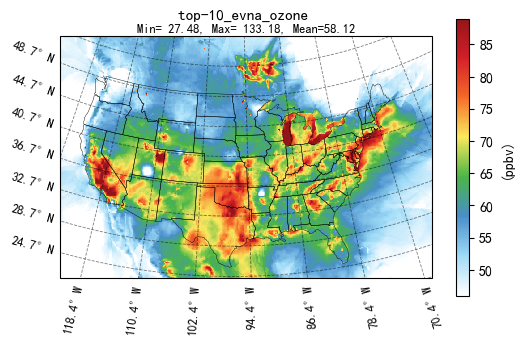

The data fusion plot for FtA_Barron's Script_top-10 evna_ozone is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/Map_2011_FtA_Barron's Script/FtA_Barron's Script_top-10_evna_ozone_data_fusion.png


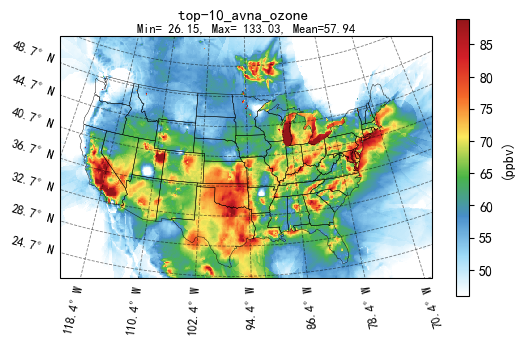

The data fusion plot for FtA_Barron's Script_top-10 avna_ozone is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/Map_2011_FtA_Barron's Script/FtA_Barron's Script_top-10_avna_ozone_data_fusion.png


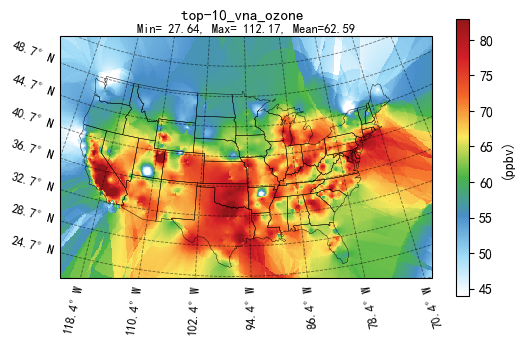

The data fusion plot for FtA_Barron's Script_top-10 vna_ozone is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/Map_2011_FtA_Barron's Script/FtA_Barron's Script_top-10_vna_ozone_data_fusion.png
Done!


In [ ]:
import os
import re
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_conc = cmaps.WhiteBlueGreenYellowRed


def extract_key_period(period):
    """
    Extract key period (e.g., JFM, AMJ) from the full period string.
    """
    key_periods = ["DJF", "MAM", "JJA", "SON", 'Annual', 'Apr-Sep', 'top-10', '98th']
    for key in key_periods:
        if key in period:
            return key
    return None


def get_prefix(filename):
    """
    Determine the prefix based on the filename.
    If the filename contains 'daily' or 'IA', return 'IA'; otherwise, return 'AI'.
    """
    if "daily" in filename.lower() or "FtA" in filename:
        return "FtA"
    return "AtF"


def get_year(filename):
    """
    Extract the year from the filename (assuming the year is in the range 2011-2020).
    """
    match = re.search(r"(20[1-2][0-9])", filename)
    if match:
        return match.group(1)
    return None


def get_axis_label(filename, period=None, year=None):
    """
    Generate the axis label based on the filename.
    - If the filename contains 'DFT', the label is 'DFT'.
    - If the filename does not contain 'DFT', the label is 'Python'.
    - Combine with the prefix (IA or AI), period, and year to form the final label.
    """
    prefix = get_prefix(filename)
    if "DFT" in filename.upper():
        label = "DFT"
    elif "BarronResult" in filename:
        label = "Barron's Result"
    elif "BarronScript" in filename:
        label = "Barron's Script"
    elif "Python" in filename:
        label = "Python"
    elif "EQUATES" in filename:
        label = "EQUATES"
    elif "Harvard" in filename:
        label = "Harvard"
    elif "BarronHarvard" in filename:
        label = "BarronHarvard"
    else:
        label = "unkown"

    if period and year:
        return f"{prefix}"
    elif period:
        return f"{prefix}"
    elif year:
        return f"{prefix}_{label}"
    return f"{prefix}_{label}"


def plot_us_map(
        fusion_output_file,
        model_file,
        base_save_path=None,
        boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
        variable_settings=None,
        key_periods=None
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file: the data fusion output file
    @param {string} model_file: the model file used for data fusion
    @param {string} base_save_path: the base path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {dict} variable_settings: dictionary of settings for each variable
    @param {list} key_periods: list of key periods to plot
    @return None
    """
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    df_data = pd.read_csv(fusion_output_file)
    if "Period" not in df_data.columns:
        print("The data fusion file does not contain the Period column!")
        return

    year = get_year(fusion_output_file)
    label = get_axis_label(fusion_output_file, year=year)

    if base_save_path:
        try:
            if not os.path.exists(base_save_path):
                os.makedirs(base_save_path)
                print(f"Created base directory: {base_save_path}")
            save_path = os.path.join(base_save_path, f"Map_{year}_{label}")
            if not os.path.exists(save_path):
                os.makedirs(save_path)
                print(f"Created directory: {save_path}")
            else:
                print(f"Directory already exists: {save_path}")
        except OSError as e:
            print(f"Error creating directory: {e}")
            return
    else:
        save_path = None

    layout = None
    periods = df_data["Period"].unique()

    for period in tqdm(periods):
        key_period = extract_key_period(period)
        if key_periods and key_period not in key_periods:
            continue  # Skip periods not in key_periods

        df_period = df_data[df_data["Period"] == period]
        if key_period:
            period_label = f"{label}_{key_period}"
        else:
            period_label = label
        period = (
            period.replace("_daily_DF", "")
           .replace("average", "Avg.")
           .replace("Average", "Avg.")
        )

        for variable, settings in variable_settings.items():
            if variable not in df_period.columns:
                print(f"Variable {variable} not found in data for period {period}. Skipping...")
                continue

            grid_concentration = df_period[variable].values.reshape(longitudes.shape)

            period_specific_settings = settings.get('period_specific', {})
            value_range = period_specific_settings.get(key_period, {}).get('value_range')

            if value_range is None:
                vmax_conc = np.nanpercentile(grid_concentration, 99.5)
                vmin_conc = np.nanpercentile(grid_concentration, 0.5)
                value_range = (vmin_conc, vmax_conc)

            dict_data = {}
            get_multiple_data(
                dict_data,
                # dataset_name=f"{label}:{period}_{variable}",
                dataset_name=f"{period}_{variable}",
                variable_name=f"",
                grid_x=longitudes,
                grid_y=latitudes,
                grid_concentration=grid_concentration,
            )

            fig = show_maps(
                dict_data,
                unit=settings.get('unit', "ppbv"),
                cmap=settings.get('cmap_conc', cmap_conc),
                show_lonlat=settings.get('show_lonlat', True),
                projection=proj,
                is_wrf_out_data=settings.get('is_wrf_out_data', True),
                boundary_file=boundary_json_file,
                show_original_grid=settings.get('show_original_grid', True),
                panel_layout=settings.get('panel_layout', layout),
                title_fontsize=settings.get('title_fontsize', 11),
                xy_title_fontsize=settings.get('xy_title_fontsize', 9),
                show_dependenct_colorbar=settings.get('show_dependenct_colorbar', True),
                value_range=value_range,
                show_domain_mean=settings.get('show_domain_mean', True),
            )

            if save_path is not None:
                save_file = os.path.join(save_path, f"{period_label}_{variable}_data_fusion.png")
                fig.savefig(save_file, dpi=500)
                print(f"The data fusion plot for {period_label} {variable} is saved to {save_file}")


if __name__ == "__main__":
    base_save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output"
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    file_list = ["/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronScript_ALL_2011_FtAIndex_top10fs.csv"]

    key_periods = ['top-10']

    variable_settings = {
        'evna_ozone': {
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True,
            'period_specific': {
                "DJF": {"value_range": (None, None)},
                "MAM": {"value_range": (None, None)},
                "JJA": {"value_range": (None, None)},
                "SON": {"value_range": (None, None)},
                "Annual": {"value_range": (None, None)},
                "Apr-Sep": {"value_range": (None, None)},
                "top-10": {"value_range": (46, 89)},
                "98th": {"value_range": (None, None)}
            }
        },
        'avna_ozone': {
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True,
            'period_specific': {
                "DJF": {"value_range": (None, None)},
                "MAM": {"value_range": (None, None)},
                "JJA": {"value_range": (None, None)},
                "SON": {"value_range": (None, None)},
                "Annual": {"value_range": (None, None)},
                "Apr-Sep": {"value_range": (None, None)},
                "top-10": {"value_range": (46, 89)},
                "98th": {"value_range": (None, None)}
            }
        },
        'vna_ozone': {
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True,
            'period_specific': {
                "DJF": {"value_range": (None, None)},
                "MAM": {"value_range": (None, None)},
                "JJA": {"value_range": (None, None)},
                "SON": {"value_range": (None, None)},
                "Annual": {"value_range": (None, None)},
                "Apr-Sep": {"value_range": (None, None)},
                "top-10": {"value_range": (44, 83)},
                "98th": {"value_range": (None, None)}
            }
        }
    }

    for file in file_list:
        plot_us_map(file, model_file, base_save_path, variable_settings=variable_settings, key_periods=key_periods)
    print("Done!")